In [212]:
import matplotlib.pyplot as plt
import numpy as np

from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

from lmfit import Model

READ ME:
1) Inserire il proprio path dei dati da analizzare in una variabile apposita
2) Inserire tutti gli aggiustamenti che servono per fare il fit di un dato canale all'interno di un if


In [213]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data


In [214]:
PATH_SAM="../../../Dati/Spettri_Sam/Cs/Run_Cs_Full_ChargeHistos_5_30_2024.dat"
edge_N, bin_N = load_histo(PATH_SAM)

    
edge_N = edge_N[0]
bin_N = bin_N[0]

rebin_fact = 1
bin_N = rebin(bin_N, rebin_fact)
tmp = []
for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)


Text(0, 0.5, 'counts')

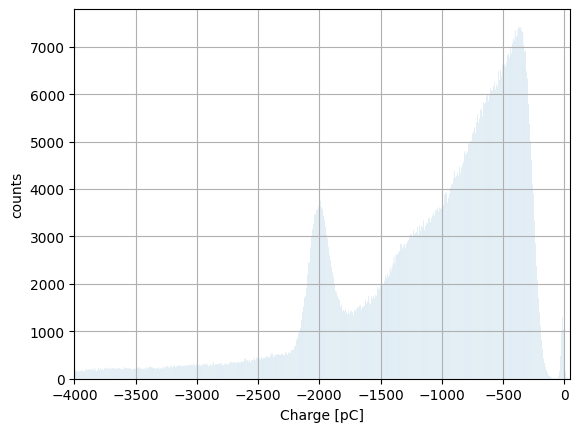

In [215]:
lim_N = [-4000, 50]
plt.bar(centers_N, bin_N, width = 1, snap = False, alpha = 1)
plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

In [216]:
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

In [217]:
np.where(err_N == 0)

(array([], dtype=int64),)

In [221]:
#DEFINIAMO IL MODELLO
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide
sigmoid2 = StepModel(form = "logistic", prefix = "s2_") #Sigmoide




#DEFINIAMO IL MODELLO
Step1   = StepModel(prefix='fd1_', form = "logistic") #Esponenziale 
Step2   = StepModel(prefix='fd2_', form = "logistic") #Esponenziale 
Step3   = StepModel(prefix='fd3_', form = "logistic") #Esponenziale 

Step4   = StepModel(prefix='fd4_', form = "logistic") #Esponenziale 



gauss  = GaussianModel(prefix='g1_')    #Gaussiana 

gauss2  = GaussianModel(prefix='g2_')    #Gaussiana 


sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide


params = Step1.guess(bin_N, x=centers_N)
params.update(Step2.guess(bin_N, x=centers_N))
params.update(Step3.guess(bin_N, x=centers_N))


params.update(sigmoid1.guess(bin_N, x=centers_N))
params.update(gauss.guess(bin_N, x=centers_N))

params.update(gauss2.guess(bin_N, x=centers_N))
params.update(Step4.guess(bin_N, x=centers_N))



params["fd1_amplitude"].min = 0
params["fd2_amplitude"].min = 0
params["fd3_amplitude"].min = 0
params["fd4_amplitude"].min = 0

params["fd1_center"].max= 0
params["fd2_center"].max= 0
params["fd3_center"].max= 0
params["fd4_center"].max= 0





params["fd1_amplitude"].value = 1000
params["fd1_center"].value = -2000
params["fd1_sigma"].value = 170


params["fd2_amplitude"].value = 5000
params["fd2_center"].value = -700
params["fd2_sigma"].value = 200


params["fd3_amplitude"].value = 2000
params["fd3_center"].value = -0.4
params["fd3_sigma"].value = 1700


params["s1_amplitude"].value = 1
params["s1_amplitude"].vary = False

params["s1_center"].value = -250  
params["s1_sigma"].value = 30

params["s1_center"].max = 0
params["s1_center"].min = -1000  

params["s1_sigma"].max = 100
params["s1_sigma"].min = 0


params["g1_center"].value = -13
params["g1_sigma"].value = 11
params["g1_height"].value = 1200

params["g1_center"].min = -40
params["g1_center"].max = 5

params["g2_center"].value = -2000
params["g2_height"].value = 2800
params["g2_sigma"].value = 80


params["fd4_center"].value = -1400
params["fd4_amplitude"].value = 1400
params["fd4_sigma"].value = 50


params["fd4_amplitude"].max = 2000





def const1(x):
    return 1


model = (Step1 + Step2 + Step3 + gauss2 + Step4) * (Model(const1) - sigmoid1) + gauss 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


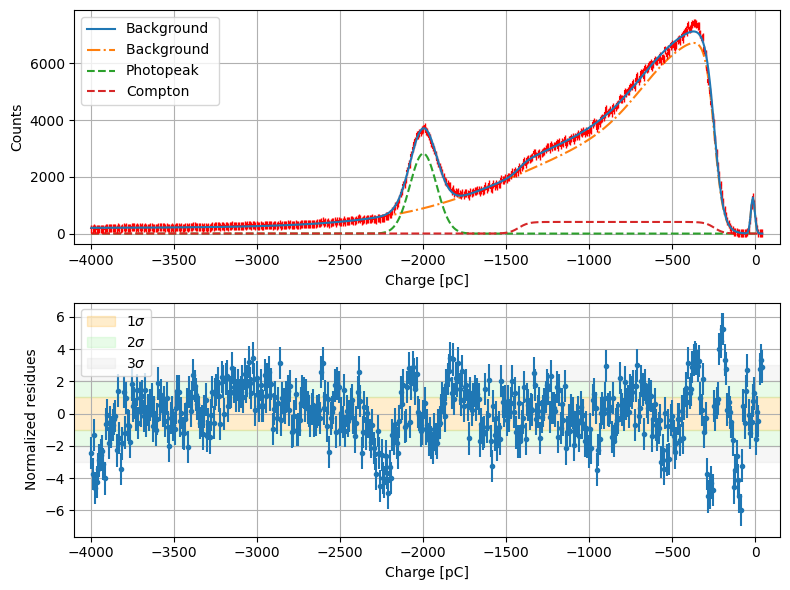

In [222]:
#FIT

result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti

ax1.plot(centers_N, (comps['fd1_'] + comps['fd2_'] + comps['fd3_'] + comps['g2_'] + comps['fd4_']) * (1 - comps['s1_']) + comps['g1_'], label='Background', zorder = 10)
ax1.plot(centers_N, (comps['fd1_'] + comps['fd2_'] + comps['fd3_']) * (1 - comps['s1_']) + comps['g1_'], label='Background ', ls = "-.")

ax1.plot(centers_N, comps['g2_'] * (1 - comps['s1_']), label='Photopeak', ls = "--")
ax1.plot(centers_N, comps['fd4_'] * (1 - comps['s1_']), label='Compton', ls = "--")



ax1.legend()
ax1.errorbar(centers_N, bin_N, err_N, color = "red", fmt='|')
ax1.grid()

residueCs = bin_N - result.best_fit
norm_resCs = residueCs / err_N

ax2.errorbar(centers_N, norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
ax1.set_xlim([-4100, 150])
ax2.set_xlim([-4100, 150])


plt.show()



In [220]:
print(result.fit_report())

[[Model]]
    ((((((Model(step, prefix='fd1_', form='logistic') + Model(step, prefix='fd2_', form='logistic')) + Model(step, prefix='fd3_', form='logistic')) + Model(gaussian, prefix='g2_')) + Model(step, prefix='fd4_', form='logistic')) * (Model(const1) - Model(step, prefix='s1_', form='logistic'))) + Model(gaussian, prefix='g1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 11136
    # data points      = 500
    # variables        = 20
    chi-square         = 1547.16144
    reduced chi-square = 3.22325299
    Akaike info crit   = 604.784550
    Bayesian info crit = 689.076712
    R-squared          = 0.99999930
[[Variables]]
    fd1_amplitude:  3673.35886 +/- 1066.39452 (29.03%) (init = 1000)
    fd1_center:    -1436.28978 +/- 126.818732 (8.83%) (init = -2000)
    fd1_sigma:      384.597496 +/- 52.4126442 (13.63%) (init = 170)
    fd2_amplitude:  3546.29956 +/- 587.679914 (16.57%) (init = 5000)
    fd2_center:    -672.080720 +/- 13.3006618 (1.98%) (i